In [1]:
import pandas as pd
import numpy as np
import os
import copy
import statsmodels.api as sm
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats.mstats import winsorize
from scipy import stats
import seaborn as sns
import matplotlib as mpl 
mpl.style.use("seaborn")
from sklearn.preprocessing import StandardScaler
drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


In [2]:
project_dir = os.getcwd() + "/drive/MyDrive/15.451 - GIC Project"
data = pd.read_excel(os.path.join(project_dir, "data/Copy of ie_data.xls"), sheet_name="Data", skiprows=7)
data.tail()

,Date,P,D,E,CPI,Fraction,Rate GS10,Price,Dividend,Price.1,Earnings,Earnings.1,CAPE,Unnamed: 13,TR CAPE,Unnamed: 15,Yield,Returns,Returns.1,Real Return,Real Return.1,Returns.2
1805,2021.06,4238.49,57.865042,158.74,271.696,2021.458333,1.52,4258.878899,58.143403,2.708807e+06,159.503623,101450.284227,36.696312,NaN,40.148114,NaN,0.030762,1.019847,52.320805,NaN,NaN,NaN
1806,2021.07,4363.71,NaN,NaN,273.003,2021.541667,1.32,4363.712857,NaN,2.775485e+06,NaN,NaN,37.443491,NaN,40.891936,NaN,0.032617,1.004823,53.103769,NaN,NaN,NaN
1807,2021.08,4454.21,NaN,NaN,273.656,2021.625000,1.28,4443.569584,NaN,2.826277e+06,NaN,NaN,38.090426,NaN,41.567547,NaN,0.032526,1.000136,53.232483,NaN,NaN,NaN
1808,2021.09,4493.28,NaN,NaN,273.983,2021.708333,1.29,4477.204062,NaN,2.847670e+06,NaN,NaN,38.342280,NaN,41.811062,NaN,0.032220,NaN,53.176244,NaN,NaN,NaN
1809,NaN,Sept 2021 P is Sept 9 close,NaN,NaN,Aug/Sept 2021 CPI estimated,NaN,Sept 2021 GS10 is Sept 3rd value,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Drop last row
data.drop(data.tail(1).index,inplace=True) 
data.tail()

,Date,P,D,E,CPI,Fraction,Rate GS10,Price,Dividend,Price.1,Earnings,Earnings.1,CAPE,Unnamed: 13,TR CAPE,Unnamed: 15,Yield,Returns,Returns.1,Real Return,Real Return.1,Returns.2
1804,2021.05,4167.85,57.787824,148.56,269.195,2021.375000,1.62,4226.807396,58.605283,2.685353e+06,150.661512,95717.473520,36.552152,NaN,40.014713,NaN,0.028818,1.010550,52.255601,NaN,NaN,NaN
1805,2021.06,4238.49,57.865042,158.74,271.696,2021.458333,1.52,4258.878899,58.143403,2.708807e+06,159.503623,101450.284227,36.696312,NaN,40.148114,NaN,0.030762,1.019847,52.320805,NaN,NaN,NaN
1806,2021.07,4363.71,NaN,NaN,273.003,2021.541667,1.32,4363.712857,NaN,2.775485e+06,NaN,NaN,37.443491,NaN,40.891936,NaN,0.032617,1.004823,53.103769,NaN,NaN,NaN
1807,2021.08,4454.21,NaN,NaN,273.656,2021.625000,1.28,4443.569584,NaN,2.826277e+06,NaN,NaN,38.090426,NaN,41.567547,NaN,0.032526,1.000136,53.232483,NaN,NaN,NaN
1808,2021.09,4493.28,NaN,NaN,273.983,2021.708333,1.29,4477.204062,NaN,2.847670e+06,NaN,NaN,38.342280,NaN,41.811062,NaN,0.032220,NaN,53.176244,NaN,NaN,NaN


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Calculate 2 and 5 Years Annualized Expected Real Equity Return
n, p = data.shape
return_2 = []
return_5 = []
for i, row in data.iterrows():

    if i+24 < n:
        return_2.append((data.loc[i+24, "Price.1"]/data.loc[i, "Price.1"])**(1/2)-1)
    else:
        return_2.append(np.nan)
    
    if i+60 < n:
        return_5.append((data.loc[i+60, "Price.1"]/data.loc[i, "Price.1"])**(1/5)-1)
    else:
        return_5.append(np.nan)

data["Real_Return_2"] = return_2
data["Real_Return_5"] = return_5

# Calculate 2 and 5 Years Annualized Real Yield of Long-term Bond
yield_2 = []
yield_5 = []
for i, row in data.iterrows():

    if i-24 >= 0:
        yield_2.append(data.loc[i, "Rate GS10"]/100-((data.loc[i, "CPI"]/data.loc[i-24, "CPI"])**(1/2)-1))
    else:
        yield_2.append(np.nan)
    
    if i-60 >= 0:
        yield_5.append(data.loc[i, "Rate GS10"]/100-((data.loc[i, "CPI"]/data.loc[i-60, "CPI"])**(1/5)-1))
    else:
        yield_5.append(np.nan)

data["Real_Yield_2"] = yield_2
data["Real_Yield_5"] = yield_5

In [6]:
# Select varialbles of interest and sample period
df = data[["Date", "Rate GS10", "CAPE", "Yield", "Real Return", "Real Return.1", 
           "Returns.2", "Real_Return_2", "Real_Return_5", "Real_Yield_2", 
           "Real_Yield_5"]].copy()
df.rename(columns={"Rate GS10": "10Y_Nominal_Yield", "Yield": "Excess_CAPE_Yield", "Real Return": "Real_Returns_Equity_10Y", 
                   "Real Return.1": "Real_Returns_Bond_10Y", "Returns.2": "Excess_Real_Returns_Equity_10Y", 
                   "Real_Return_2": "Real_Returns_Equity_2Y", "Real_Return_5": "Real_Returns_Equity_5Y", 
                   "Real_Yield_2": "Real_Yield_2Y", "Real_Yield_5": "Real_Yield_5Y"}, inplace=True)
# Drop NAs, sample period: 1881.01-2011.08
df_clean = df.dropna()
df_clean

,Date,10Y_Nominal_Yield,CAPE,Excess_CAPE_Yield,Real_Returns_Equity_10Y,Real_Returns_Bond_10Y,Excess_Real_Returns_Equity_10Y,Real_Returns_Equity_2Y,Real_Returns_Equity_5Y,Real_Yield_2Y,Real_Yield_5Y
120,1881.01,3.7,18.473952,-0.010489,0.045353,0.056468,-0.011115,-0.010091,0.056730,-0.029738,0.064821
121,1881.02,3.69333,18.147258,-0.011393,0.046774,0.056199,-0.009425,-0.018835,0.063602,-0.029070,0.062798
122,1881.03,3.68667,18.270119,-0.013123,0.042423,0.054885,-0.012462,-0.013208,0.059318,-0.035246,0.062731
123,1881.04,3.68,17.950108,-0.007504,0.045971,0.054635,-0.008665,0.008850,0.061809,-0.046904,0.059005
124,1881.05,3.67333,18.869719,-0.008881,0.041157,0.054786,-0.013628,-0.021196,0.051492,-0.041596,0.053821
...,...,...,...,...,...,...,...,...,...,...,...
1683,2011.04,3.46,23.143929,0.032908,0.122922,0.019353,0.103569,0.090403,0.101572,0.007610,0.012378
1684,2011.05,3.17,23.059492,0.035985,0.122663,0.016578,0.106085,0.113027,0.099596,0.003781,0.009531
1685,2011.06,3,22.100831,0.039284,0.127718,0.014863,0.112854,0.125678,0.109218,0.007016,0.008453
1686,2011.07,3,22.610982,0.038642,0.127113,0.016208,0.110905,0.126789,0.110192,0.005750,0.008875


In [7]:
df["Log_CAPE"] = np.log(df["CAPE"])
df["CAPE_Inverse"] = 1/df["CAPE"]
df["Real_Yield_10Y"] = df.CAPE_Inverse - df.Excess_CAPE_Yield
# Descriptive statistics
df.describe()

,Date,CAPE,Excess_CAPE_Yield,Real_Returns_Equity_10Y,Real_Returns_Bond_10Y,Excess_Real_Returns_Equity_10Y,Real_Returns_Equity_2Y,Real_Returns_Equity_5Y,Real_Yield_2Y,Real_Yield_5Y,Log_CAPE,CAPE_Inverse,Real_Yield_10Y
count,1809.000000,1689.000000,1689.000000,1688.000000,1688.000000,1688.000000,1785.000000,1749.000000,1785.000000,1749.000000,1689.000000,1689.000000,1689.000000
mean,1945.940547,17.205097,0.046787,0.068713,0.025676,0.043037,0.077416,0.071505,0.023236,0.023088,2.763301,0.068786,0.021999
std,43.529812,7.038601,0.044269,0.051265,0.035520,0.048857,0.131341,0.078810,0.045758,0.032992,0.410662,0.030577,0.024770
min,1871.010000,4.784241,-0.025777,-0.059239,-0.054197,-0.099817,-0.436454,-0.132330,-0.147592,-0.106352,1.565327,0.022625,-0.036078
25%,1908.090000,11.895760,0.015711,0.037107,-0.001465,0.012844,0.001933,0.019214,0.004824,0.007119,2.476182,0.047817,0.006579
50%,1946.050000,16.378480,0.034904,0.068403,0.022427,0.036029,0.074828,0.072200,0.023176,0.022571,2.795968,0.061056,0.023181
75%,1984.010000,20.913092,0.066782,0.105631,0.056468,0.065182,0.160573,0.121356,0.040884,0.039101,3.040375,0.084064,0.038826
max,2021.090000,44.197940,0.235340,0.199585,0.109818,0.195984,0.542323,0.333465,0.172417,0.122252,3.788678,0.209020,0.076360



Regression given by Shiller(1996):
$$
Real Returns Equity_{t+k}=\alpha+\beta_k \log{CAPE_{t}}+\varepsilon_{t+k,k}
$$
The intuition behind the regression is that under low-interest rate regimes, CAPE is unusually high. Currently SP500 CAPE sits at 39.6, 2nd highest of all time. A high CAPE ratio suggests that equities are overvalued, resulting in low subsequent returns while a low CAPE is suggestive of higher future returns. 


In [51]:
# Regression of different sample period

split = 2007.01

reg_data = df[df.Date < split][["Log_CAPE", "Real_Returns_Equity_10Y"]].dropna()
reg1_before = sm.OLS(reg_data.Real_Returns_Equity_10Y, sm.add_constant(reg_data[["Log_CAPE"]]))
result1_before = reg1_before.fit()

reg_data = df[df.Date >= split][["Log_CAPE", "Real_Returns_Equity_10Y"]].dropna()
reg1_after = sm.OLS(reg_data.Real_Returns_Equity_10Y, sm.add_constant(reg_data[["Log_CAPE"]]))
result1_after = reg1_after.fit()

# Entire period
reg_data = df[["Log_CAPE", "Real_Returns_Equity_10Y"]].dropna()
reg1_all = sm.OLS(reg_data.Real_Returns_Equity_10Y, sm.add_constant(reg_data[["Log_CAPE"]]))
result1_all = reg1_all.fit()

print(result1_after.summary())

                               OLS Regression Results                              
Dep. Variable:     Real_Returns_Equity_10Y   R-squared:                       0.622
Model:                                 OLS   Adj. R-squared:                  0.615
Method:                      Least Squares   F-statistic:                     88.74
Date:                     Wed, 01 Dec 2021   Prob (F-statistic):           5.43e-13
Time:                             02:39:48   Log-Likelihood:                 148.66
No. Observations:                       56   AIC:                            -293.3
Df Residuals:                           54   BIC:                            -289.3
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

Given the poor correlation between historical CAPE and forwards returns, we hypothesize two reasons for the poor predictive power of CAPE during low interest rate regimes:


1.   Bond yields are depressed during low-interest regimes, which prompts investors to allocate more of their portfolio into equity, thus making equity more expensive.
2.   Lower interest rates also lowers the discount rate, which increases equity valuation.

It appears that CAPE is not able to capture the relative premium in investing in equity over bonds.

Given the two reasons proposed above, we introduce the new measure proposed by Shiller (2020) adjusting for interest rate regime, which is defined as the inverse current CAPE ratio minus the current 10-year real interest rate, i.e.

$$
ExcessCAPEYield_t=\frac{1}{CAPE_t}-10YearRealInterestRate_t,
$$
Excess CAPE Yield (ECY) tells us the premium an investor might expect by investing in equities over bonds. Based on this new measure, we can rerun the regression 
$$
Real Returns Equity_{t+k}=\alpha+\beta_k ExcessCAPEYield_t+\varepsilon_{t+k,k}
$$
as follows

In [38]:
reg_data = df[df.Date < split][["Excess_CAPE_Yield", "Real_Returns_Equity_10Y"]].dropna()
reg2_before = sm.OLS(reg_data.Real_Returns_Equity_10Y, sm.add_constant(reg_data[["Excess_CAPE_Yield"]]))
result2_before = reg2_before.fit()

reg_data = df[df.Date >= split][["Excess_CAPE_Yield", "Real_Returns_Equity_10Y"]].dropna()
reg2_after = sm.OLS(reg_data.Real_Returns_Equity_10Y, sm.add_constant(reg_data[["Excess_CAPE_Yield"]]))
result2_after = reg2_after.fit()

reg_data = df[["Excess_CAPE_Yield", "Real_Returns_Equity_10Y"]].dropna()
reg2_all = sm.OLS(reg_data.Real_Returns_Equity_10Y, sm.add_constant(reg_data[["Excess_CAPE_Yield"]]))
result2_all = reg2_all.fit()
print(result2_all.summary())

                               OLS Regression Results                              
Dep. Variable:     Real_Returns_Equity_10Y   R-squared:                       0.344
Model:                                 OLS   Adj. R-squared:                  0.343
Method:                      Least Squares   F-statistic:                     819.5
Date:                     Wed, 01 Dec 2021   Prob (F-statistic):          2.55e-145
Time:                             01:01:58   Log-Likelihood:                 2748.4
No. Observations:                     1568   AIC:                            -5493.
Df Residuals:                         1566   BIC:                            -5482.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

And notice that $R^2$ has increased from 0.299 to 0.344, and the $t$-statistic of constant term is significantly larger.

Based on this result, we can further include 10 years bond yield as a control variable, and regress the excess equity return on excess CAPE yield and 10 years real interest rate, i.e. running the regression

\begin{aligned}
Real Returns Equity_{t+k}=\alpha+\beta_{1,k} \log CAPE_t+\beta_{2,k}Real Returns 10Y Bonds_{t+k}+\varepsilon_{t+k,k}
\end{aligned}

as the adjustment to interest rate regime.

In [52]:
reg_data = df[df.Date < split][["Log_CAPE", "Real_Yield_10Y", "Real_Returns_Equity_10Y"]].dropna()
reg3_before = sm.OLS(reg_data.Real_Returns_Equity_10Y, sm.add_constant(reg_data[["Log_CAPE", "Real_Yield_10Y"]]))
result3_before = reg3_before.fit()

reg_data = df[df.Date >= split][["Log_CAPE", "Real_Yield_10Y", "Real_Returns_Equity_10Y"]].dropna()
reg3_after = sm.OLS(reg_data.Real_Returns_Equity_10Y, sm.add_constant(reg_data[["Log_CAPE", "Real_Yield_10Y"]]))
result3_after = reg3_after.fit()

reg_data = df[["Log_CAPE", "Real_Yield_10Y", "Real_Returns_Equity_10Y"]].dropna()
reg3_all = sm.OLS(reg_data.Real_Returns_Equity_10Y, sm.add_constant(reg_data[["Log_CAPE", "Real_Yield_10Y"]]))
result3_all = reg3_all.fit()

print(result3_after.summary())

                               OLS Regression Results                              
Dep. Variable:     Real_Returns_Equity_10Y   R-squared:                       0.760
Model:                                 OLS   Adj. R-squared:                  0.751
Method:                      Least Squares   F-statistic:                     84.01
Date:                     Wed, 01 Dec 2021   Prob (F-statistic):           3.68e-17
Time:                             02:40:13   Log-Likelihood:                 161.43
No. Observations:                       56   AIC:                            -316.9
Df Residuals:                           53   BIC:                            -310.8
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

And the result yields the highest $R^2$ so far, and all coefficients of the covariates are statistically significant.

In [40]:
df["Forecast_Real_Stock_Returns_10Y_CAPE"] = result1_all.predict(sm.add_constant(df[["Log_CAPE"]]))
df["Forecast_Real_Stock_Returns_10Y_ECY"] = result3_all.predict(sm.add_constant(df[["Log_CAPE", "Real_Yield_10Y"]]))

In [41]:
df.describe()

,Date,CAPE,Excess_CAPE_Yield,Real_Returns_Equity_10Y,Real_Returns_Bond_10Y,Excess_Real_Returns_Equity_10Y,Real_Returns_Equity_2Y,Real_Returns_Equity_5Y,Real_Yield_2Y,Real_Yield_5Y,Log_CAPE,CAPE_Inverse,Real_Yield_10Y,Forecast_Real_Stock_Returns_10Y_CAPE,Forecast_Real_Stock_Returns_10Y_ECY
count,1809.000000,1689.000000,1689.000000,1688.000000,1688.000000,1688.000000,1785.000000,1749.000000,1785.000000,1749.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000
mean,1945.940547,17.205097,0.046787,0.068713,0.025676,0.043037,0.077416,0.071505,0.023236,0.023088,2.763301,0.068786,0.021999,0.062775,0.064098
std,43.529812,7.038601,0.044269,0.051265,0.035520,0.048857,0.131341,0.078810,0.045758,0.032992,0.410662,0.030577,0.024770,0.030057,0.031122
min,1871.010000,4.784241,-0.025777,-0.059239,-0.054197,-0.099817,-0.436454,-0.132330,-0.147592,-0.106352,1.565327,0.022625,-0.036078,-0.012273,-0.007745
25%,1908.090000,11.895760,0.015711,0.037107,-0.001465,0.012844,0.001933,0.019214,0.004824,0.007119,2.476182,0.047817,0.006579,0.042496,0.041305
50%,1946.050000,16.378480,0.034904,0.068403,0.022427,0.036029,0.074828,0.072200,0.023176,0.022571,2.795968,0.061056,0.023181,0.060384,0.055855
75%,1984.010000,20.913092,0.066782,0.105631,0.056468,0.065182,0.160573,0.121356,0.040884,0.039101,3.040375,0.084064,0.038826,0.083790,0.084411
max,2021.090000,44.197940,0.235340,0.199585,0.109818,0.195984,0.542323,0.333465,0.172417,0.122252,3.788678,0.209020,0.076360,0.150457,0.164505


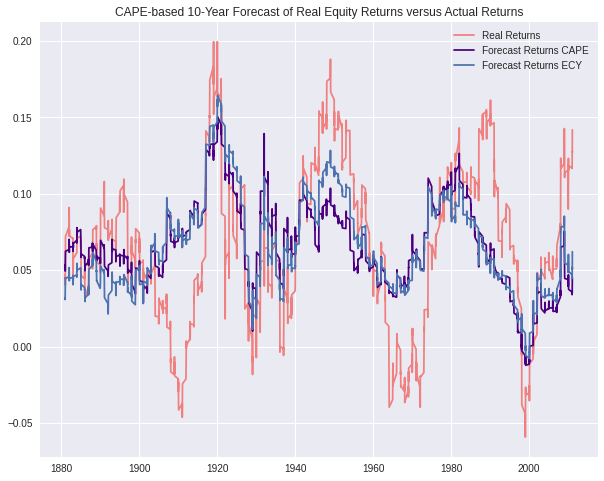

In [42]:
df_clean = df[["Date", "Real_Returns_Equity_10Y", "Forecast_Real_Stock_Returns_10Y_CAPE", "Forecast_Real_Stock_Returns_10Y_ECY"]].dropna()

plt.figure(figsize=(10, 8))
plt.plot(df_clean.Date, df_clean.Real_Returns_Equity_10Y, label="Real Returns", color='lightcoral')
plt.plot(df_clean.Date, df_clean.Forecast_Real_Stock_Returns_10Y_CAPE, label="Forecast Returns CAPE", color='#4b0082')
plt.plot(df_clean.Date, df_clean.Forecast_Real_Stock_Returns_10Y_ECY, label="Forecast Returns ECY")
plt.title("CAPE-based 10-Year Forecast of Real Equity Returns versus Actual Returns")
plt.legend()
# plt.grid()
plt.show()

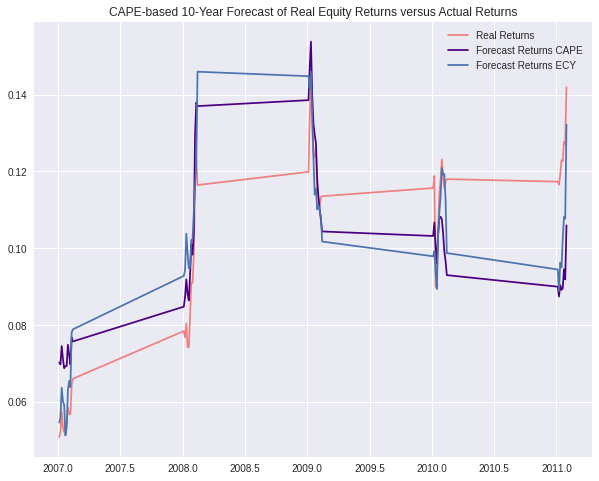

In [44]:
df["Forecast_Real_Stock_Returns_10Y_CAPE"] = result1_after.predict(sm.add_constant(df[["Log_CAPE"]]))
df["Forecast_Real_Stock_Returns_10Y_ECY"] = result3_after.predict(sm.add_constant(df[["Log_CAPE", "Real_Yield_10Y"]]))

df_clean = df[["Date", "Real_Returns_Equity_10Y", "Forecast_Real_Stock_Returns_10Y_CAPE", "Forecast_Real_Stock_Returns_10Y_ECY"]].dropna()

split = 2007.01

df_clean = df_clean[df_clean.Date >= split]

plt.figure(figsize=(10, 8))
plt.plot(df_clean.Date, df_clean.Real_Returns_Equity_10Y, label="Real Returns", color='lightcoral')
plt.plot(df_clean.Date, df_clean.Forecast_Real_Stock_Returns_10Y_CAPE, label="Forecast Returns CAPE", color='#4b0082')
plt.plot(df_clean.Date, df_clean.Forecast_Real_Stock_Returns_10Y_ECY, label="Forecast Returns ECY")
plt.title("CAPE-based 10-Year Forecast of Real Equity Returns versus Actual Returns")
plt.legend()
# plt.grid()
plt.show()


## Plots
### Scatterplot of stock returns and long term interest rates

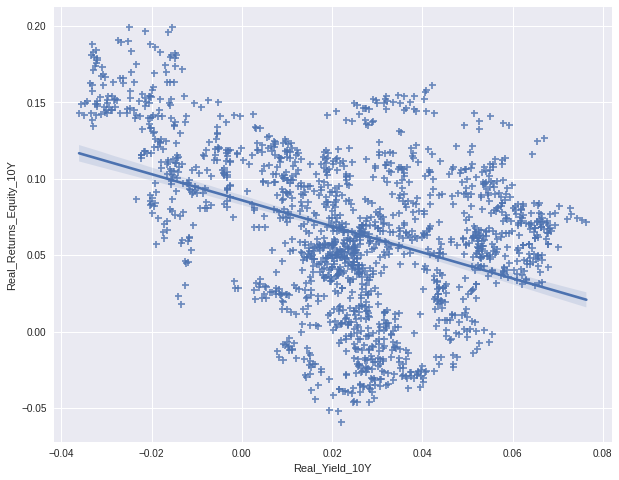

In [ ]:
plt.figure(figsize=(10, 8))
# plt.grid()
sns.regplot(x=df["Real_Yield_10Y"], y=df.Real_Returns_Equity_10Y, marker="+")

### Time Series of CAPE and 10 years nominal Interest Rate

Text(0, 0.5, 'Interest Rate')

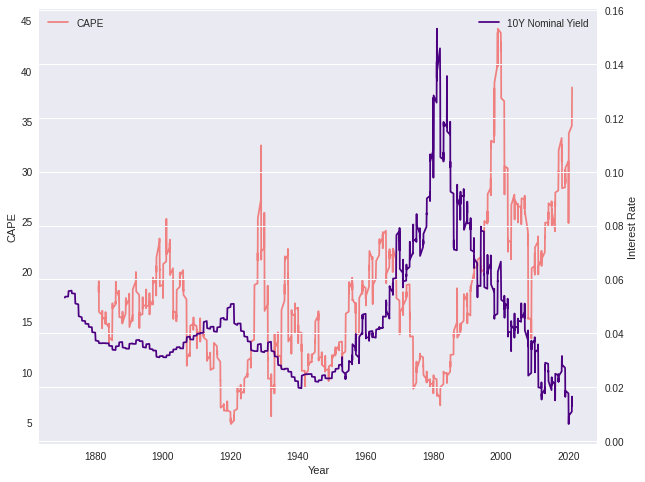

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.plot(df.Date, df.CAPE, label="CAPE", color='lightcoral')
ax2 = ax.twinx()
ax2.plot(df.Date, df['10Y_Nominal_Yield']/100, label="10Y Nominal Yield", color='#4b0082')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid()
ax.set_xlabel("Year")
ax.set_ylabel("CAPE")
ax2.set_ylabel("Interest Rate")

In [ ]:
!pip install stargazer

In [ ]:
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
# Regression results samlpe period: 1880-2007
stargazer = Stargazer([result1_before,result2_before,result3_before])

HTML(stargazer.render_html())

In [ ]:
# Regression results samlpe period: 2007-2021
stargazer = Stargazer([result1_after,result2_after,result3_after])

HTML(stargazer.render_html())

In [ ]:
# Regression results entire period
stargazer = Stargazer([result1_all,result2_all,result3_all])

HTML(stargazer.render_html())

In [ ]:
df.columns

Index(['Date', '10Y_Nominal_Yield', 'CAPE', 'Excess_CAPE_Yield',
       'Real_Returns_Equity_10Y', 'Real_Returns_Bond_10Y',
       'Excess_Real_Returns_Equity_10Y', 'Real_Returns_Equity_2Y',
       'Real_Returns_Equity_5Y', 'Real_Yield_2Y', 'Real_Yield_5Y', 'Log_CAPE',
       'CAPE_Inverse', 'Real_Yield_10Y',
       'Forecast_Real_Stock_Returns_CAPE_10Y',
       'Forecast_Real_Stock_Returns_10Y_ECY',
       'Forecast_Real_Stock_Returns_10Y_CAPE'],
      dtype='object')

In [46]:
tab = pd.DataFrame()
for year in ["2Y", "5Y", "10Y"]:

    reg_data = df[["Real_Returns_Equity_"+year, "CAPE_Inverse", "Real_Yield_"+year]].dropna()

    reg_CAPE = sm.OLS(reg_data["Real_Returns_Equity_"+year], sm.add_constant(reg_data[["CAPE_Inverse"]]))
    result_CAPE = reg_CAPE.fit()

    reg_ECY = sm.OLS(reg_data["Real_Returns_Equity_"+year] -reg_data["Real_Yield_"+year], sm.add_constant(reg_data[["CAPE_Inverse", "Real_Yield_"+year]]))
    result_ECY = reg_ECY.fit()

    # Predictions
    a1 = result_CAPE.predict(sm.add_constant(df)[df.Date==2020.01][["const", "CAPE_Inverse"]]).values[0]
    a2 = result_CAPE.predict(sm.add_constant(df)[df.Date==2021.08][["const", "CAPE_Inverse"]]).values[0]
    b1 = result_ECY.predict(sm.add_constant(df)[df.Date==2020.01][["const", "CAPE_Inverse", "Real_Yield_"+year]]).values[0]
    b2 = result_ECY.predict(sm.add_constant(df)[df.Date==2021.08][["const", "CAPE_Inverse", "Real_Yield_"+year]]).values[0]
    preds = [a1, a2, b1, b2]
    tab[year] = preds

In [47]:
tab = tab.T
tab.columns = ["CAPE_before_pandemic", "CAPE_current", "ECY_before_pandemic", "ECY_current"]
tab

,CAPE_before_pandemic,CAPE_current,ECY_before_pandemic,ECY_current
2Y,0.032052,0.025153,0.021443,0.024518
5Y,0.027358,0.020760,0.023490,0.025473
10Y,0.029520,0.023909,0.047357,0.052116


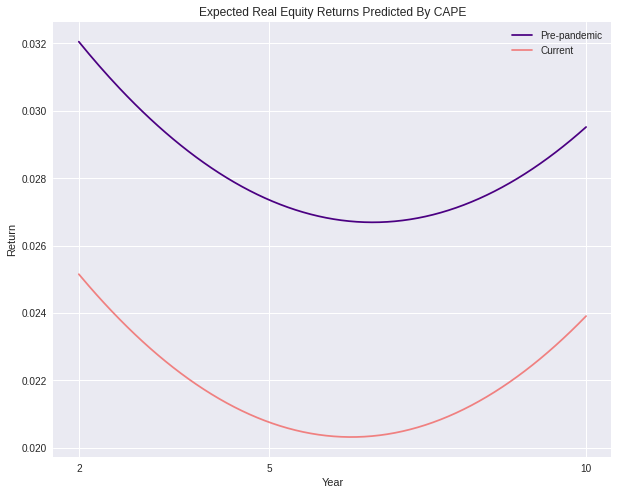

In [48]:
from scipy.interpolate import make_interp_spline, BSpline
from scipy.interpolate import CubicSpline

#create smooth line chart 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

#create data
x = np.array([2, 5, 10])
y = np.array(tab.CAPE_before_pandemic)
#define x as 200 equally spaced values between the min and max of original x 
xnew = np.linspace(x.min(), x.max(), 200) 
#define spline
spl = CubicSpline(x, y)
y_smooth = spl(xnew)
ax.plot(xnew, y_smooth, label="Pre-pandemic", color='#4b0082')

#create data
x = np.array([2, 5, 10])
y = np.array(tab.CAPE_current)
#define x as 200 equally spaced values between the min and max of original x 
xnew = np.linspace(x.min(), x.max(), 200) 
#define spline
spl = CubicSpline(x, y)
y_smooth = spl(xnew)
ax.plot(xnew, y_smooth, label="Current", color='lightcoral')
# ax.grid()
ax.legend()
ax.set_xticks([2, 5, 10])
ax.set_xlabel("Year")
ax.set_ylabel("Return")
plt.title("Expected Real Equity Returns Predicted By CAPE")
plt.show()

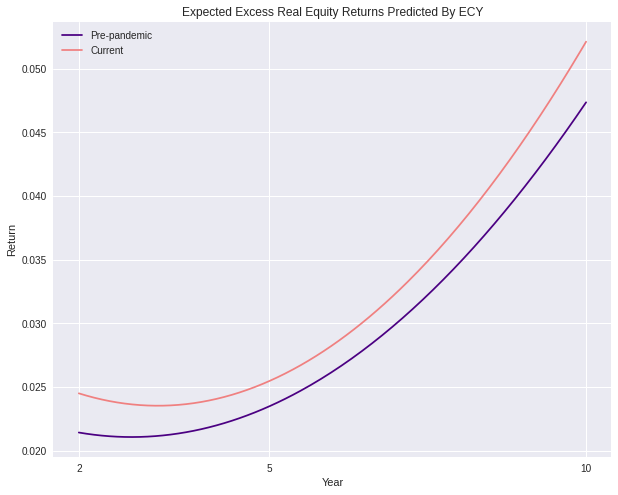

In [50]:
#create smooth line chart 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

#create data
x = np.array([2, 5, 10])
y = np.array(tab.ECY_before_pandemic)
#define x as 200 equally spaced values between the min and max of original x 
xnew = np.linspace(x.min(), x.max(), 200) 
#define spline
spl = CubicSpline(x, y)
y_smooth = spl(xnew)
ax.plot(xnew, y_smooth, label="Pre-pandemic", color='#4b0082')

#create data
x = np.array([2, 5, 10])
y = np.array(tab.ECY_current)
#define x as 200 equally spaced values between the min and max of original x 
xnew = np.linspace(x.min(), x.max(), 200) 
#define spline
spl = CubicSpline(x, y)
y_smooth = spl(xnew)
ax.plot(xnew, y_smooth, label="Current", color='lightcoral')
# ax.grid()
ax.legend()
ax.set_xticks([2, 5, 10])
ax.set_xlabel("Year")
ax.set_ylabel("Return")
plt.title("Expected Excess Real Equity Returns Predicted By ECY")
plt.show()

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1804   -0.001460
1805   -0.003511
1806   -0.005910
1807   -0.006273
1808   -0.006140
Name: Real_Yield_10Y, Length: 1809, dtype: float64